<div style="display: top; background-image:url('https://d1.awsstatic.com/SageMaker/SageMaker%20reInvent%202020/ImgHead_Mohave.3b1df33baa5f71b53237bfa6911fb3adc4902c0e.png');background-position: center ;background-repeat: no-repeat;background-size: 100%; padding-top:20px;">
<div style="color:#FFFFFF; text-align: top;padding-bottom: 25px; padding-left: 15px"><h1 style="font-weight: 900;">Convolutional Neural Networks (CNNs)</h1>
</div>
</div>
<br>

In this notebook, we build a Convolutional Neural Network (CNN) by using built-in CNN architectures in [PyTorch](https://pytorch.org/docs/stable/index.html) to train a multiclass classification model on a real-world dataset ([MINC](http://opensurfaces.cs.cornell.edu/publications/minc/)).

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Preprocess features to build the model</a>
4. <a href="#4">Training and test datasets</a>
5. <a href="#5">Create NN architecture</a>
6. <a href="#6">Train an image classifier</a>
7. <a href="#7">Test the classifier</a>
8. <a href="#8">Improvement ideas</a>

__MINC Dataset__:

In this exercise, we are working with image data from __MINC__. MINC is short for Materials in Context Database, provided by Cornell. We will use a subset of this dataset with the following classes: *brick, carpet, food, mirror, sky, water*. 

The MINC dataset is well labeled and has a moderate size thus is perfect to be our example. If you want to see the original datasets and the merged data with multiple entries, they are available under `DATA/minc-2500` folder.


In [1]:
# Ensure installation of specific libraries
!pip3 install -q torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu
!pip install -q d2l==0.14.3

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

from d2l import torch as d2l
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

First, let's  define the paths for train, validation and test dataset. 

In [3]:
path = "../../DATA/minc-2500"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")


![MINC 2500 Examples.](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png)

## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

It is a good practice to visualize what does the dataset look like! Let's define the `show_images` function and see some sample images in MINC.

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

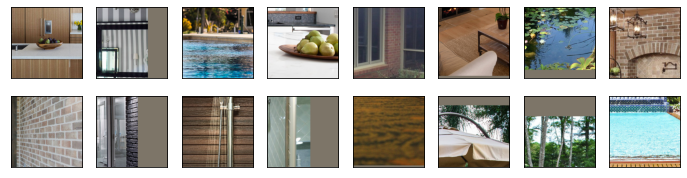

In [5]:
train_dataset = torchvision.datasets.ImageFolder(
    test_path, transform=transforms.ToTensor()
)
test_sample = torch.utils.data.DataLoader(train_dataset, batch_size=2 * 8, shuffle=True)

for data, label in test_sample:
    show_images(data, 2, 8)
    break

In [6]:
from collections import Counter

# Count the number of examples per class using Counter
Counter(train_dataset.targets)

Counter({0: 30, 1: 30, 2: 30, 3: 30, 4: 30, 5: 30})

## 3. <a name="3">Preprocess features to build the model</a>
(<a href="#0">Go to top</a>)

To load the dataset properly, we need to massage the image data a bit by some `transfom` functions. First, we load the image data and resize it to the given size (224,224). Next, we convert the image tensor of shape (C x H x W) in the range [0, 255] to a float32 torch tensor of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize an tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [7]:
transformation = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ]
)

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of PyTorch, which reads a minibatch of data with size `batch_size` each time.

## 4. <a name="3">Train \& Test Split</a>
(<a href="#0">Go to top</a>)

In [8]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformation),
    batch_size=batch_size,
    shuffle=True,
)

validation_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(val_path, transform=transformation),
    batch_size=batch_size,
    shuffle=False,
)

test_data = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformation), shuffle=False
)

## 5. <a name="22">Create NN architecture</a>
(<a href="#0">Go to top</a>)

Now it's the time to design a Convolutional neural network! First, let's initailize a `Sequential` block. In PyTorch, `Sequential` defines a container for several layers that will be chained together. Given input data, a `Sequential` passes it through the first layer, in turn passing the output as the second layer’s input and so forth.

We will build a neural netword with a 2D convolutional layer `Conv2D`, following by a 2D maxpooling layer `MaxPool2D`, a fully connected (or `Dense`) layer, and a final output `Dense` layer with output classes 23.

In [9]:
out_classes = 6

net = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # The Flatten layer collapses all axis, except the first one, into one axis.
    nn.Flatten(),
    nn.Linear(110 * 110 * 20, 128),
    nn.ReLU(),
    nn.Linear(128, out_classes),
)

Our network is almost ready to be trained! One last thing before the training is to set up the hyperparameters, such training device `device` (GPU or CPU), the number of epochs to train, the learning rate of optimization algorithms. Besides, we specify the loss function. Since this problem is a multiclass classification task, we will use `CrossEntropyLoss` as our loss funciton.

In [10]:
device = d2l.try_gpu()  # Set this to CPU or GPU depending on your training instance

epochs = 10
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

To infer the neural network "how to optimize its weights", we instantiate the `optim.<Optimizer>`, which defines the parameters to optimize over (obtainable from our net via net.parameters()) and the hyperparameters required by our optimization algorithm.

In [11]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

Below, you can find an example of a well known CNN architecture: LeNet.

![LeNet](https://d2l.ai/_images/lenet.svg "Title")


## 6. <a name="22">Train an image classifier</a>
(<a href="#0">Go to top</a>)

Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full passes through our dataset).

In [12]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    net = net.to(device)
    train_loss, val_loss, train_acc, val_acc = 0.0, 0.0, 0.0, 0.0
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for data, label in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        train_acc += (output.argmax(axis=1) == label.float()).float().mean().item()
        train_loss += loss.item()
        optimizer.step()
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for data, label in validation_loader:
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        val_acc += (output.argmax(axis=1) == label.float()).float().mean().item()
        val_loss += criterion(output, label).item()
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    val_acc /= len(validation_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(
        f"Epoch {epoch+1}: train loss {train_loss:.3f}, train acc {train_acc:.3f}, val loss {val_loss:.3f}, val acc {val_acc:.3f}"
    )

Epoch 1: train loss 1.682, train acc 0.264, val loss 1.566, val acc 0.302
Epoch 2: train loss 1.432, train acc 0.390, val loss 1.453, val acc 0.375
Epoch 3: train loss 1.288, train acc 0.501, val loss 1.249, val acc 0.490
Epoch 4: train loss 1.183, train acc 0.542, val loss 1.266, val acc 0.516
Epoch 5: train loss 1.039, train acc 0.600, val loss 1.090, val acc 0.594
Epoch 6: train loss 0.970, train acc 0.637, val loss 1.268, val acc 0.516
Epoch 7: train loss 0.900, train acc 0.679, val loss 1.002, val acc 0.630
Epoch 8: train loss 0.809, train acc 0.715, val loss 1.046, val acc 0.573
Epoch 9: train loss 0.727, train acc 0.735, val loss 1.061, val acc 0.630
Epoch 10: train loss 0.645, train acc 0.776, val loss 1.022, val acc 0.599


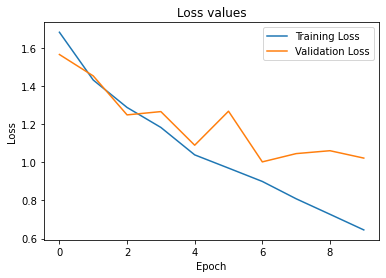

In [13]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 7. <a name="22">Test the classifier</a>
(<a href="#0">Go to top</a>)

For testing, we use the traned net to produce output classes. We can then compare to the true labels with sklearn classification report. 

In [14]:
test_pred = []
test_true = []
for data, label in test_data:
    data = data.to(device)
    label = label.to(device)
    output = net(data)
    test_pred.append(output.argmax(axis=1).cpu().numpy()[0])
    test_true.append(label.cpu().numpy()[0])

In [15]:
print(classification_report(test_true, test_pred))
print(f"Accuracy: {accuracy_score(test_true, test_pred)}")

              precision    recall  f1-score   support

           0       0.49      0.60      0.54        30
           1       0.53      0.60      0.56        30
           2       0.81      0.57      0.67        30
           3       0.61      0.47      0.53        30
           4       0.83      0.80      0.81        30
           5       0.72      0.87      0.79        30

    accuracy                           0.65       180
   macro avg       0.66      0.65      0.65       180
weighted avg       0.66      0.65      0.65       180

Accuracy: 0.65


We observe that the performance of the model is not equal per class. The dataset used for this particular example is very small. Generally image problems require several hundred or (even better) thousands of example images.

## 8. <a name="22">Improvement ideas</a>
(<a href="#0">Go to top</a>)

Generally Neural Networks are incredibly data hungry. If there aren't enough examples to learn from, it is possible to create slightly modified versions of the images by introducing rotation, shift, flip or even introduce noise.

To use this, import the following libraries and try to increase the number of samples in your dataset.


```
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
```

With these libraries you can try to create different versions of your images with e.g. `rotated_img = rotate(image, angle=45, mode = 'wrap')`.

Another idea would be to use a pre-trained model that works well for image classification tasks such as [AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/).